In [1]:
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

DATA = Path("./data/")

df = pd.read_csv(DATA / "set.csv")

In [2]:
#train/test 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
df_train = train.copy()

In [4]:
df_train.shape[0]

9600

In [5]:
#correlatin 

corr_matrix = df_train.corr(numeric_only=True)

corr_matrix['run_5k_min'].sort_values(ascending=False)

run_5k_min                1.000000
resting_hr                0.738930
systolic_bp               0.543590
ldl_mg_dL                 0.523581
body_fat_pct              0.521121
diastolic_bp              0.518694
age                       0.458561
stress_level              0.278120
smoker                    0.272254
bmi                       0.151575
triglycerides_mg_dL       0.125256
alcohol_units_per_week    0.090649
id                        0.010460
weight_kg                 0.001553
calorie_intake           -0.106119
sleep_hours              -0.180310
height_cm                -0.219144
squat_1rm_kg             -0.318893
bench_1rm_kg             -0.344854
protein_g                -0.355544
weekly_workouts          -0.497081
hdl_mg_dL                -0.521436
max_pushups              -0.623486
steps_per_day            -0.654837
vo2max                   -0.908321
Name: run_5k_min, dtype: float64

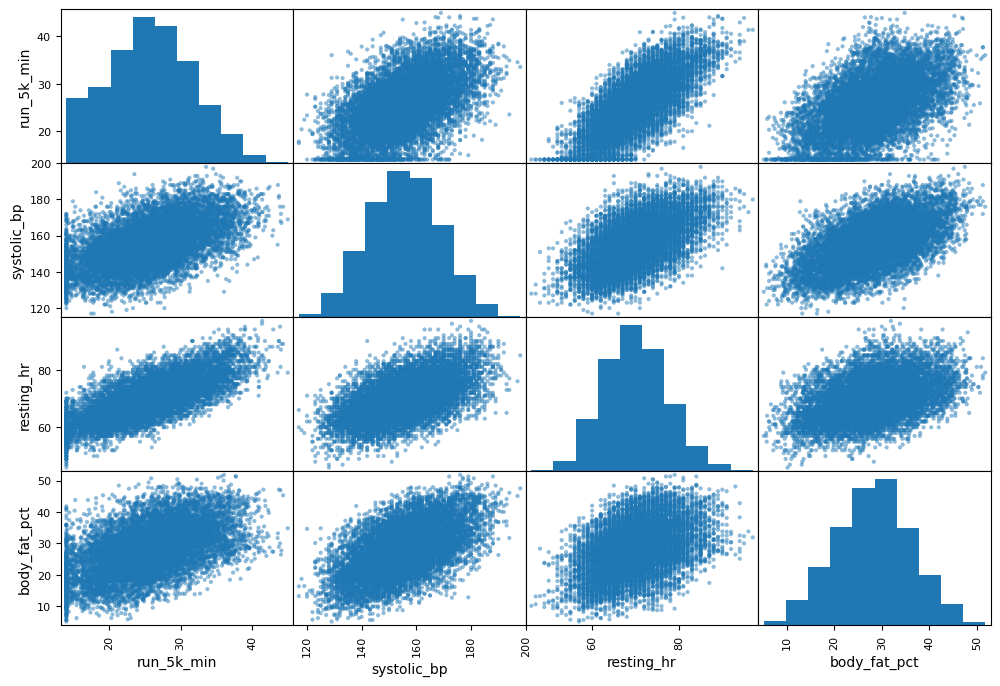

In [6]:
from pandas.plotting import scatter_matrix 

attributes = ["run_5k_min", "systolic_bp","resting_hr", "body_fat_pct"]
scatter_matrix(df_train[attributes], figsize=(12, 8))
plt.show()

In [7]:
#labels and the rest 

df_train = train.drop("run_5k_min", axis=1)
df_train_labels = train["run_5k_min"].copy()

In [8]:
#cleaning 

df_train.isna().sum()

id                        0
month                     0
age                       0
sex                       0
height_cm                 0
weight_kg                 0
bmi                       0
body_fat_pct              0
weekly_workouts           0
steps_per_day             0
sleep_hours               0
stress_level              0
calorie_intake            0
protein_g                 0
alcohol_units_per_week    0
smoker                    0
vo2max                    0
resting_hr                0
systolic_bp               0
diastolic_bp              0
bench_1rm_kg              0
squat_1rm_kg              0
max_pushups               0
ldl_mg_dL                 0
hdl_mg_dL                 0
triglycerides_mg_dL       0
dtype: int64

In [9]:
#num data 
df_train_num = df_train.select_dtypes(include=[np.number])

In [10]:
 # emissions
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_train_num)

In [11]:
outlier_pred 

array([ 1, -1,  1, ...,  1,  1,  1])

In [12]:
count_outlier = pd.DataFrame(outlier_pred, columns=["outlier_flag"], index=df_train_num.index)
count_outlier.value_counts()

outlier_flag
 1              8702
-1               898
Name: count, dtype: int64

In [13]:
df_train = df_train.iloc[outlier_pred == 1]
df_train_labels = df_train_labels.iloc[outlier_pred == 1]

Pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
#test with customs trans
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out='one-to-one')



custom_pipeline = Pipeline([
    ('log', log_transformer)
])
 # Automatic feature selection by type
numeric_features = make_column_selector(dtype_include='number')
categorical_features = make_column_selector(dtype_include='object')

 # Pipeline for numerical features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

 # Pipeline for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


full_pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_features),
        ('categorical', categorical_pipeline, categorical_features),
        ('custom', custom_pipeline, ['calorie_intake'])
    ])
)


LinearRegression

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(full_pipeline, LinearRegression())
lin_reg.fit(df_train, df_train_labels)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA0B27BF50>),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA0B585130>),
                                                                  ('custom',
                                                                   Pipeline(steps=[('log',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log'>,
                                                                                                        inverse_func=<ufunc 'exp'>))]),
                                                                   ['calorie_intake'])]))])),
                ('linearregression', LinearRegression())])

In [16]:
predictions = lin_reg.predict(df_train)

In [17]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(df_train_labels, predictions)
lin_mae = mean_absolute_error(df_train_labels, predictions)

print(f"RMSE: {lin_rmse}")
print(f"MAE: {lin_rmse}")

RMSE: 1.214892819763163
MAE: 1.214892819763163


In [18]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(lin_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Average RMSE:", lin_rmses.mean())
print("Average MAE:", lin_maes.mean())

Average RMSE: 1.2199519272461439
Average MAE: 0.9620214793252654


RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

 # creating a pipeline: preprocessing + random forest
rf_reg = make_pipeline(
    full_pipeline,
    RandomForestRegressor(
        n_estimators=200, # number of trees
        max_depth=None, # tree depth (None = all the way)
        min_samples_split=2, # minimum number of objects to split
        random_state=42,
        n_jobs=-1 # use all processor cores
    )
)

 # learning from training data
rf_reg.fit(df_train, df_train_labels)

 # predictions
forest_predictions = rf_reg.predict(df_train)

In [20]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, forest_predictions, squared=False)

rf_rmse = root_mean_squared_error(df_train_labels, forest_predictions)
rf_mae = mean_absolute_error(df_train_labels, forest_predictions)

print(f"RMSE: {rf_rmse}")
print(f"MAE: {rf_rmse}")

RMSE: 0.4810273166149222
MAE: 0.4810273166149222


In [21]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(rf_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(rf_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Average RMSE:", lin_rmses.mean())
print("Average MAE:", lin_maes.mean())

Average RMSE: 1.2995727119576084
Average MAE: 1.0276188692611214


XGBoost

In [22]:
from xgboost import XGBRegressor

 # pipeline: preprocessing + XGBoost
xgb_reg = make_pipeline(
    full_pipeline,
    XGBRegressor(
        n_estimators=500, # number of trees (boosting iterations)
        learning_rate=0.05, # learning rate
        max_depth=6, # tree depth
        subsample=0.8, # share of data for each tree
        colsample_bytree=0.8, # proportion of features for each tree
        random_state=42,
        n_jobs=-1
    )
)

 # training
xgb_reg.fit(df_train, df_train_labels)

 # predictions
xgb_predictions = xgb_reg.predict(df_train)

In [23]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, xgb_predictions, squared=False)

xgb_rmse = root_mean_squared_error(df_train_labels, xgb_predictions)
xgb_mae = mean_absolute_error(df_train_labels, xgb_predictions)

print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_rmse}")

RMSE: 0.6213010069757958
MAE: 0.6213010069757958


In [24]:
#cross-valid 
from sklearn.model_selection import cross_val_score

xgb_rmses = -cross_val_score(xgb_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
xgb_maes = -cross_val_score(xgb_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Average RMSE:", xgb_rmses.mean())
print("Average MAE:", xgb_maes.mean())

Average RMSE: 1.264027306638896
Average MAE: 1.0032378286171884


Random Search and Best Model 

In [25]:
entire_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("rf", RandomForestRegressor()),
])

#witch params there are
print(str(entire_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'rf', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__custom', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__numeric__scaler',

In [26]:
#random research 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "rf__n_estimators": randint(100, 600), # number of trees
    "rf__max_depth": [None, 5, 10, 20, 30], # tree depth
    "rf__min_samples_split": randint(2, 10), # minimum number of objects to split
    "rf__min_samples_leaf": randint(1, 5), # minimum number of objects in a sheet
    "rf__max_features": ["sqrt", "log2", None], # feature selection strategy
    "rf__bootstrap": [True, False], # use bootstrap?
    "rf__n_jobs": [-1], # use all cores
    "rf__random_state": [42], # for reproducibility
}

rnd_search = RandomizedSearchCV(
    entire_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_train, df_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001BA0B27BF50>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BA0B2E17C0>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BA0B47AF90>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BA0B2141A0>,
                                        'rf__n_jobs': [-1],
                                        'rf__random_state': [42]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [27]:
rnd_search.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': 30,
 'rf__max_features': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 314,
 'rf__n_jobs': -1,
 'rf__random_state': 42}

In [28]:
best_model = rnd_search.best_estimator_
predictions = best_model.predict(df_train)

In [29]:
best_rmses = -cross_val_score(best_model, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(best_rmses).describe()

count    10.000000
mean      1.297741
std       0.048698
min       1.203778
25%       1.274234
50%       1.307237
75%       1.330354
max       1.363180
dtype: float64

In [30]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["rf"].feature_importances_
feature_importances.round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.79, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [31]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.7937820709721167, 'numeric__vo2max'),
 (0.14539493925945315, 'numeric__steps_per_day'),
 (0.009705732983947831, 'numeric__resting_hr'),
 (0.005929745719194051, 'numeric__smoker'),
 (0.005422733501482727, 'numeric__sleep_hours'),
 (0.004134077487325444, 'numeric__stress_level'),
 (0.0033107000804549827, 'numeric__body_fat_pct'),
 (0.0029100804771219958, 'numeric__alcohol_units_per_week'),
 (0.002668628484631434, 'numeric__triglycerides_mg_dL'),
 (0.002445232838787606, 'numeric__ldl_mg_dL'),
 (0.002137191944650777, 'numeric__systolic_bp'),
 (0.001963619052003982, 'numeric__id'),
 (0.001920914762236988, 'numeric__diastolic_bp'),
 (0.001889107579436314, 'numeric__protein_g'),
 (0.0018359611048905768, 'numeric__height_cm'),
 (0.001699101714023374, 'numeric__max_pushups'),
 (0.0016458194990889208, 'numeric__hdl_mg_dL'),
 (0.0015557519945860602, 'numeric__age'),
 (0.0015503527637399468, 'numeric__bmi'),
 (0.0015440233032720655, 'numeric__squat_1rm_kg'),
 (0.0015254306045535202, 'numeric__

Test probe

In [32]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

X_test = test.drop("run_5k_min", axis=1)
y_test = test["run_5k_min"].copy()

final_predictions = final_model.predict(X_test)

 # ===Metrics ===
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 1.32
MAE:  1.03


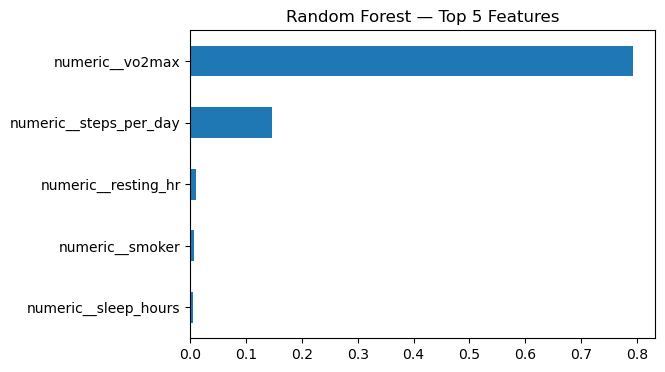

In [33]:
feat_imp = pd.Series(
    final_model.named_steps['rf'].feature_importances_,
    index=final_model.named_steps['preprocessing'].get_feature_names_out()
).sort_values(ascending=True)

feat_imp.tail(5).plot(kind='barh', figsize=(6,4), title='Random Forest — Top 5 Features')
plt.savefig("out/img/Random Forest — Top 5 Features.png", dpi=300)
plt.show()


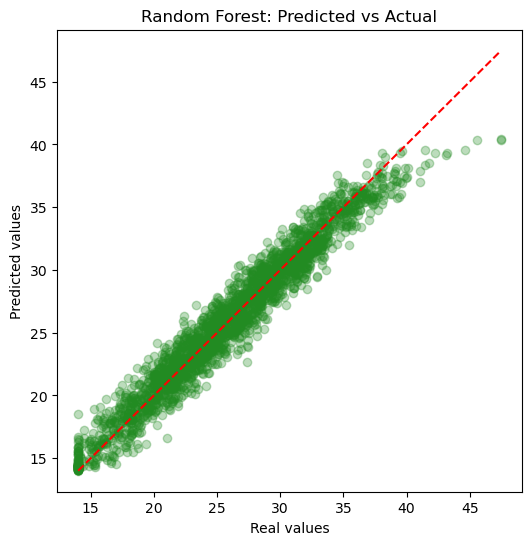

In [36]:
import matplotlib.pyplot as plt

y_pred_rf = final_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.savefig("out/img/Random Forest Predicted vs Actual.png", dpi=300)
plt.show()


Save

In [35]:
import joblib
joblib.dump(final_model, "out/models/linear_run_5k_min.pkl")

['out/models/linear_run_5k_min.pkl']